In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from scipy.ndimage import gaussian_filter, median_filter, binary_opening, binary_closing
from scipy.ndimage import binary_dilation, generate_binary_structure
import sys
import tifffile as tf
import torch

sys.path.append("../")
from data_prep import collect, load, draw, save
from data_prep.image import Image
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from scipy.ndimage import zoom

scale_file = "/home/brysongray/data/scaling_gold.csv"
scale_df = pd.read_csv(scale_file)

swc_dir = "/home/brysongray/data/gold166/"
swc_paths = [f for x in os.walk(swc_dir) for f in glob(os.path.join(x[0], "*.swc")) if "ano" not in f and "stamp" not in f]
swc_out = "/home/brysongray/data/gold166_swc_scaled"

# get tif images
img_dir = "/home/brysongray/data/gold166_tifs"
img_files = os.listdir(img_dir)
img_out = "/home/brysongray/data/gold166_tifs_scaled"
for f in img_files:
    if os.path.exists(os.path.join(img_out, f.split("/")[-1])):
        continue
    # get scale info for img
    img_fname = f.split(".")[0]
    row = [i for i,swc_file in enumerate(scale_df["swc_file"].tolist()) if img_fname in swc_file]
    try:
        row = row[0]
    except IndexError:
        continue
    xy, z = scale_df.iloc[row]["x_y_pix_size":"z_pix_size"]

    # load image
    img = tf.imread(os.path.join(img_dir,f))

    # Check if resampling is needed
    swc_path = [x for x in swc_paths if img_fname in x]
    try:
        swc_path = swc_path[0]
    except IndexError:
        continue
    swc_list = load.swc(swc_path)
    if xy != z:
        # Calculate the scaling factor for z dimension
        scale_factor = z / xy
        
        # Resize along z axis to make isotropic
        scale_factors = (scale_factor, 1, 1)  # Only scale z dimension
        img = zoom(img, scale_factors, order=1)
        
        new_list = []
        for x in swc_list:
            x[4] = x[4]*scale_factor
            new_list.append(x)
        print(f"Resampled image from shape {img.shape} to make isotropic pixels (xy={xy}, z={z})")
    else:
        print(f"Image already has isotropic pixels (xy={xy}, z={z})")
        new_list = swc_list
    tf.imwrite(os.path.join(img_out, f.split("/")[-1]), img)
    save.write_swc(new_list, os.path.join(swc_out, swc_path.split('/')[-1]))

In [37]:
img_dir = "/home/brysongray/data/gold166_tifs_scaled/"
swc_dir = "/home/brysongray/data/gold166_swc_scaled/"

# i=34
i=1
img_files = os.listdir(img_dir)
img_file = img_files[i]
img = tf.imread(os.path.join(img_dir,img_file))

swc_files = os.listdir(swc_dir)
swc_file = [f for f in swc_files if img_file.split('.')[0] in f][0]
swc_list = load.swc(os.path.join(swc_dir, swc_file))

sections, section_graph, branches, terminals, scale = load.parse_swc_list(swc_list, adjust=False)
segments = []
for section in sections.values():
    segments.append(section)
segments = torch.concatenate(segments)

density = draw.draw_neuron_density(segments[...,:3], img.shape, width=3)
mask = draw.draw_neuron_mask(density, threshold=5.0)

branch_mask = Image(torch.zeros_like(mask))
for point in branches:
    branch_mask.draw_point(point[:3], radius=3, binary=True, value=1, channel=0)

loading file: /home/brysongray/data/gold166_swc_scaled/091204c2.tif.v3dpbd.swc


## View neuron with skeleton

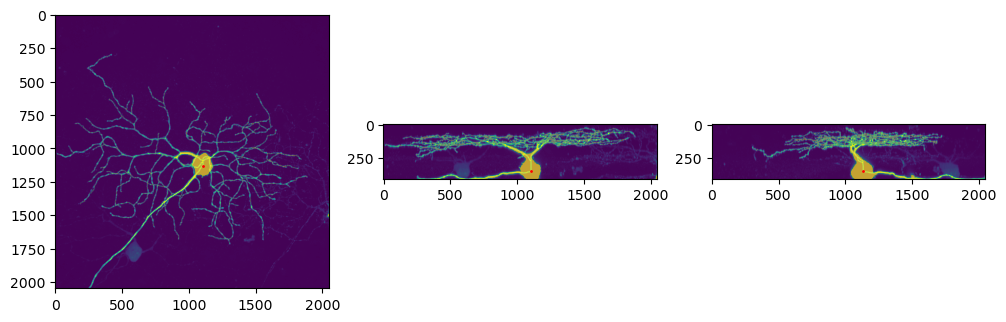

In [40]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0), alpha=0.3)
# ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.4)
ax[1].imshow(img.max(1))
ax[1].imshow(mask[0].amax(1), alpha=0.3)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(mask[0].amax(2), alpha=0.3)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)

## View skeleton with branches

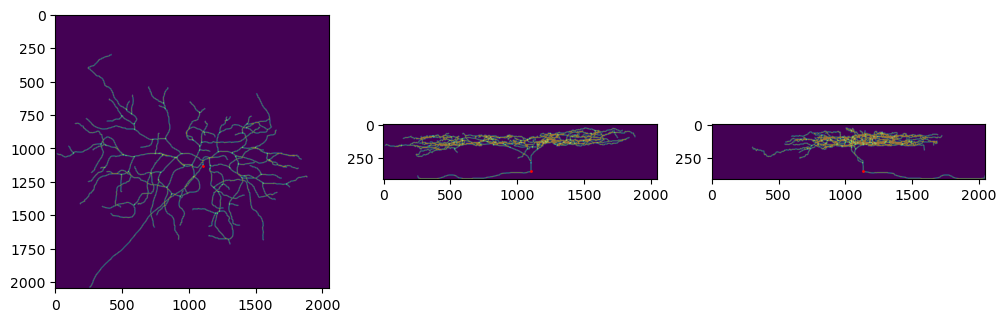

In [43]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0))
ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.5)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[1].imshow(mask[0].amax(1))
ax[1].imshow(branch_mask.data[0].amax(1), alpha=0.5)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)
ax[2].imshow(mask[0].amax(2))
ax[2].imshow(branch_mask.data[0].amax(2), alpha=0.5)


## View neuron with skeleton using radius info

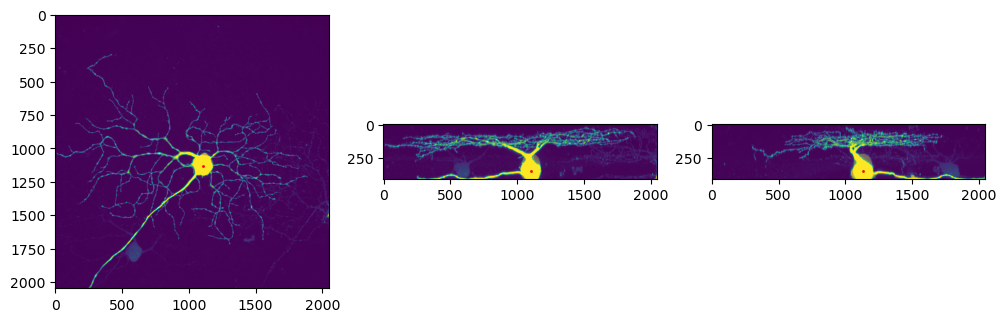

In [ ]:
density = draw.draw_neuron_density(segments, img.shape, width=3)
mask = draw.draw_neuron_mask(density, threshold=5.0)

branch_mask = Image(torch.zeros_like(mask))
for point in branches:
    branch_mask.draw_point(point[:3], radius=point[3].item(), binary=True, value=1, channel=0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0), aspect="auto")
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0), alpha=0.3)
ax[1].imshow(img.max(1))
ax[1].imshow(mask[0].amax(1), alpha=0.3)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(mask[0].amax(2), alpha=0.3)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)

## View skeleton with branches using radius info

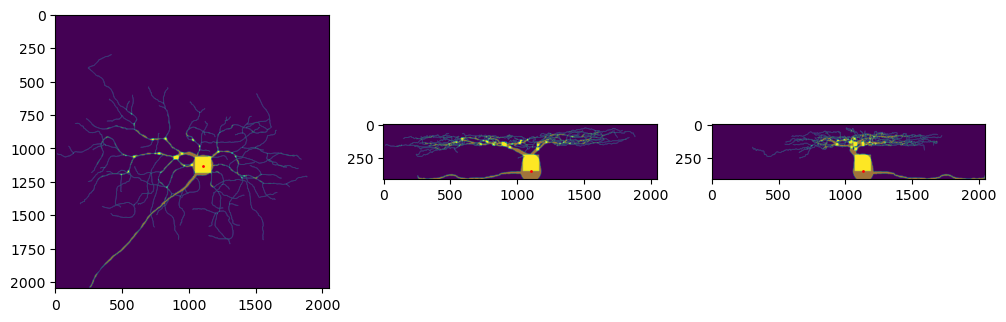

In [46]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0))
ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.5)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[1].imshow(mask[0].amax(1))
ax[1].imshow(branch_mask.data[0].amax(1), alpha=0.5)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)
ax[2].imshow(mask[0].amax(2))
ax[2].imshow(branch_mask.data[0].amax(2), alpha=0.5)

## Segment soma by filtering the mask for segments with a large radius

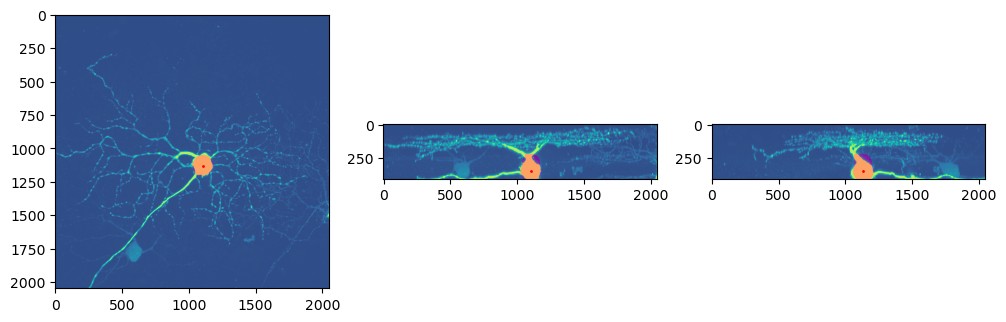

In [36]:
large_segments_coords = np.argwhere(segments[:,:,3] >= 20.0)
large_segments = segments[large_segments_coords[0]]
density = draw.draw_neuron_density(large_segments, img.shape, width=3)
large_segments_mask = draw.draw_neuron_mask(density, threshold=5.0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[0].imshow(large_segments_mask[0].amax(0), cmap='cool', alpha=0.3)
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[1].imshow(img.max(1))
ax[1].imshow(large_segments_mask[0].amax(1), cmap='cool', alpha=0.3)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(large_segments_mask[0].amax(2), cmap='cool', alpha=0.3)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)